In [1]:
import matplotlib.pyplot as plt
# ^^^ pyforest auto-imports - don't write above this line
import pandas as pd
import numpy as np
from nilearn import plotting, image, masking
from tqdm import tqdm
import seaborn  as sns
import ptitprince as pt
import matplotlib.colors as colors

/home/javi/Documentos/software/nilearn/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


Subjects used = 176
The minimum proportion of subjects without NaNs shouuld be 50.0%, which sets the maximum number of NaN's per voxel as = 87
number of grey matter voxels: 207583


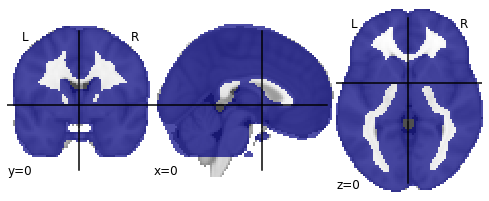

In [2]:
demo_data = pd.read_csv("../data/Thomas_Javi_ML_Share_PIP_Reappraisal_IMT_Longitudinal_02_NOV_2020.csv")
subject_fullsample =  demo_data.iloc[:,2].to_numpy()
print("Subjects used = %d" % len(subject_fullsample))

nan_props = 0.5
thr = len(subject_fullsample) - int(nan_props*len(subject_fullsample))
print("The minimum proportion of subjects without NaNs"
      " shouuld be %.1f%%, which sets the maximum number of NaN's per voxel as = %d" % (nan_props*100, thr-1)) 
# -1 in print here because the threshold is less than 

gm_mask = "../data/reslicedER_grey25grey25.nii" 
plotting.plot_roi(gm_mask, cut_coords=(0,0,0))
pass

gm_voxels = image.load_img(gm_mask).get_fdata().sum()
print("number of grey matter voxels: %d" % gm_voxels)

# Name for each contrast in the files
lookneg_vs_lookneut = "con_0001"
regneg_vs_lookneg = "con_0002"

In [3]:
contrast = lookneg_vs_lookneut
er_1_half_pattern =  "../data/split_half_data/sub-%s/SplitHalf/ER_1stHalf/%s.nii"
er_2_half_pattern =  "../data/split_half_data/sub-%s/SplitHalf/ER_2ndHalf/%s.nii"

# Load split-half contrast images
er_half_1 = image.load_img([er_1_half_pattern % (subj, contrast) for subj in subject_fullsample])
er_half_2 = image.load_img([er_2_half_pattern % (subj, contrast) for subj in subject_fullsample])

# OR gate, to indicate any voxel with a NaN
nans_both = image.math_img("np.logical_or(img1, img2)", 
                           img1=image.math_img("np.isnan(img)", img=er_half_1),
                           img2=image.math_img("np.isnan(img)", img=er_half_2))
# For each voxel, sum subjects with NaN and take only those under the permitted threshold
nans_mask_data = np.sum(nans_both.get_fdata(), axis=3) < thr # less than, so the threshold is not taken
nans_mask = image.new_img_like(nans_both, nans_mask_data)
    

In [3]:
def compute_consistency_map(contrast):
    er_1_half_pattern =  "../data/split_half_data/sub-%s/SplitHalf/ER_1stHalf/%s.nii"
    er_2_half_pattern =  "../data/split_half_data/sub-%s/SplitHalf/ER_2ndHalf/%s.nii"
    
    # Load split-half contrast images
    er_half_1 = image.load_img([er_1_half_pattern % (subj, contrast) for subj in subject_fullsample])
    er_half_2 = image.load_img([er_2_half_pattern % (subj, contrast) for subj in subject_fullsample])
    
    # OR gate, to indicate any voxel with a NaN
    nans_both = image.math_img("np.logical_or(img1, img2)", 
                               img1=image.math_img("np.isnan(img)", img=er_half_1),
                               img2=image.math_img("np.isnan(img)", img=er_half_2))
    
    # For each voxel, sum subjects with NaN and take only those under the permitted threshold
    nans_mask_data = np.sum(nans_both.get_fdata(), axis=3) < thr # less than, so the threshold is not taken
    nans_mask = image.new_img_like(nans_both, nans_mask_data)
    
    # Intersect this mask with grey matter mask
    mask_img = masking.intersect_masks([nans_mask, gm_mask], threshold=1)
    
    # Extract data within these masks
    er_half_1_flat = masking.apply_mask(er_half_1, mask_img, ensure_finite=False)    
    er_half_2_flat = masking.apply_mask(er_half_2, mask_img, ensure_finite=False)
    
    sb_reliability = np.zeros(er_half_1_flat.shape[1])
    for i_voxel, (x,y) in tqdm(enumerate(zip(er_half_1_flat.T, er_half_2_flat.T))):
    
        nan_x = np.isnan(x)
        nan_y = np.isnan(y)
        nan_cond = np.logical_or(nan_x, nan_y)

        # Compute Pearson Correlation (without NaN's)
        r = np.corrcoef(x[~nan_cond], y[~nan_cond])[0,1]

        # Apply Spearman-Brown correction
        r_corrected = (2*r)/(1+r)
        sb_reliability[i_voxel] = r_corrected
    
    sb_reliability[sb_reliability<0]=0
    return masking.unmask(sb_reliability, mask_img)

# Regulate Negative vs Look Negative

203403it [00:15, 12882.18it/s]


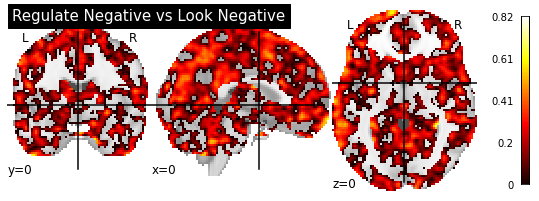

In [4]:
reap_neg_reliability = compute_consistency_map(regneg_vs_lookneg)
plotting.plot_stat_map(reap_neg_reliability, cut_coords=(0,0,0), title="Regulate Negative vs Look Negative")

In [7]:
# Save to disk
reap_neg_reliability.to_filename("../images/RegNeg_LookNeg_SpearmanBrown_reliability.nii.gz")
from nilearn.image import load_img
reap_neg_reliability = load_img("../images/RegNeg_LookNeg_SpearmanBrown_reliability.nii.gz")

In [20]:
n_voxels = image.math_img("(img > %f) & (img <= %f)" % (0, 0.35), 
                          img=reap_neg_reliability).get_fdata().sum()
print("number of voxels with low reliability = %d (%f percentage)" % (n_voxels, n_voxels/gm_voxels*100))

n_voxels = image.math_img("(img > %f) & (img <= %f)" % (0.35, 0.67), 
                          img=reap_neg_reliability).get_fdata().sum()
print("number of voxels with medium reliability = %d (%f percentage)" % (n_voxels, n_voxels/gm_voxels*100))

n_voxels = image.math_img("(img > %f)" % 0.67, 
                          img=reap_neg_reliability).get_fdata().sum()
print("number of voxels with high reliability = %d (%f percentage)" % (n_voxels, n_voxels/gm_voxels*100))

number of voxels with low reliability = 136489 (65.751214 percentage)
number of voxels with medium reliability = 12372 (5.959997 percentage)
number of voxels with high reliability = 13 (0.006263 percentage)


/home/javi/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


max = 0.819177


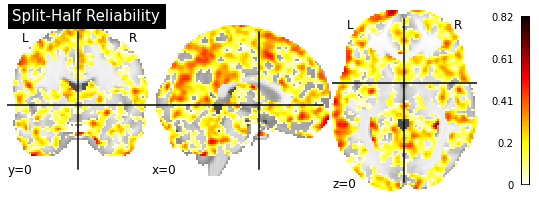

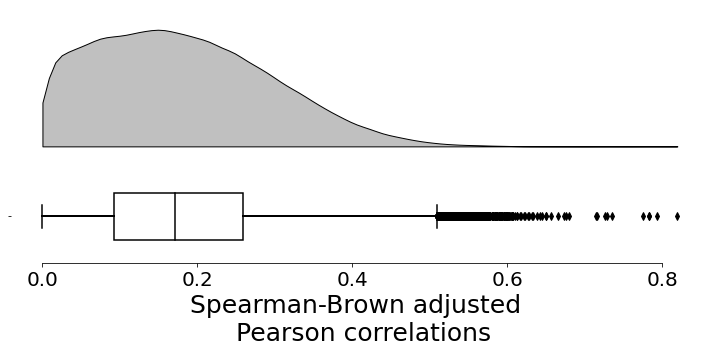

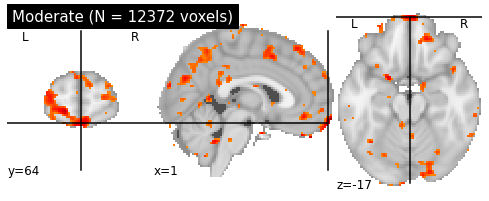

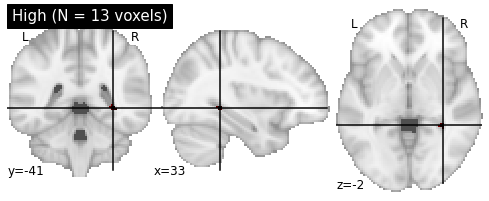

In [10]:
cmap = plotting.cm.cold_white_hot

plotting.plot_stat_map(reap_neg_reliability, cut_coords=(0,0,0), title="Split-Half Reliability", 
                      cmap=cmap)
plt.savefig("../plots/split_half_reliabilities/reg_neg_look_neg/reg_neg_look_neg_reliability.svg", dpi=300)
plt.savefig("../plots/split_half_reliabilities/reg_neg_look_neg/reg_neg_look_neg_reliability.png", dpi=300)
plt.savefig("../plots/split_half_reliabilities/reg_neg_look_neg/reg_neg_look_neg_reliability.pdf", dpi=300)

fig, ax = plt.subplots(figsize=(10, 5))
violin = pt.half_violinplot(reap_neg_reliability.get_fdata()[reap_neg_reliability.get_fdata()>0],  
                   bw = .1, cut = 0,
                   color="silver", linewidth=1, alpha=1,
                   scale = "area", width = .5, inner = None, orient = "h", ax=ax)

violin.collections[0].set_edgecolors('black')

sns.boxplot(reap_neg_reliability.get_fdata()[reap_neg_reliability.get_fdata()>0], 
               color = "black", width = .10, zorder = 10,
               showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
               showfliers=True, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = "h", ax=ax)
plt.xlabel("Spearman-Brown adjusted \n Pearson correlations", size=25)
plt.tick_params(labelsize=20)
plt.ylim([0.1, -0.45])
sns.despine(offset=0, trim=True, ax=ax)
plt.tight_layout()
plt.savefig("../plots/split_half_reliabilities/reg_neg_look_neg/reg_neg_look_neg_reliability_histo.svg", dpi=300)
plt.savefig("../plots/split_half_reliabilities/reg_neg_look_neg/reg_neg_look_neg_reliability_histo.png", dpi=300)
plt.savefig("../plots/split_half_reliabilities/reg_neg_look_neg/reg_neg_look_neg_reliability_histo.pdf", dpi=300)

vmax = reap_neg_reliability.get_fdata().max()
print("max = %f" % vmax)
moderate_rel = image.math_img("img*((img > %f) & (img <= %f))" % (0.35, 0.67), img=reap_neg_reliability)

n_voxels = np.sum(moderate_rel.get_fdata()>0)
plotting.plot_stat_map(moderate_rel, 
                       vmax=vmax,
                       cmap = cmap,
                       #cmap=colors.ListedColormap([cmap(0.75)], N=1),#plt.cm.Wistia,
                       title="Moderate (N = %d voxels)" % n_voxels,
                       colorbar=False)

plt.savefig("../plots/split_half_reliabilities/reg_neg_look_neg/reg_neg_look_neg_reliability_moderate.svg", dpi=300)
plt.savefig("../plots/split_half_reliabilities/reg_neg_look_neg/reg_neg_look_neg_reliability_moderate.png", dpi=300)
plt.savefig("../plots/split_half_reliabilities/reg_neg_look_neg/reg_neg_look_neg_reliability_moderate.pdf", dpi=300)

high_rel = image.math_img("img*(img > %f)" % (0.67), img=reap_neg_reliability)
n_voxels = np.sum(high_rel.get_fdata()>0)

plotting.plot_stat_map(high_rel, 
                       vmax=vmax,
                       cmap = cmap,
                       #cmap=colors.ListedColormap([cmap(0.9)], N=1),
                       title="High (N = %d voxels)" % n_voxels,
                       colorbar=False)


plt.savefig("../plots/split_half_reliabilities/reg_neg_look_neg/reg_neg_look_neg_reliability_high.svg", dpi=300)
plt.savefig("../plots/split_half_reliabilities/reg_neg_look_neg/reg_neg_look_neg_reliability_high.png", dpi=300)
plt.savefig("../plots/split_half_reliabilities/reg_neg_look_neg/reg_neg_look_neg_reliability_high.pdf", dpi=300)

# Look Negative vs Look Neutral

203403it [00:16, 12618.66it/s]


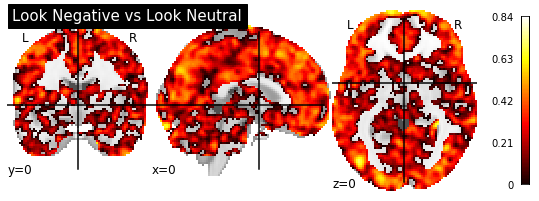

In [11]:
look_neg_reliability = compute_consistency_map(lookneg_vs_lookneut)
plotting.plot_stat_map(look_neg_reliability, cut_coords=(0,0,0), title="Look Negative vs Look Neutral")

In [12]:
# Save to disk
look_neg_reliability.to_filename("../images/LookNeg_LookNeut_SpearmanBrown_reliability.nii.gz")
look_neg_reliability = image.load_img("../images/LookNeg_LookNeut_SpearmanBrown_reliability.nii.gz")

In [16]:
n_voxels = image.math_img("(img > %f) & (img <= %f)" % (0, 0.35), 
                          img=look_neg_reliability).get_fdata().sum()
print("number of voxels with low reliability = %d (%f percentage)" % (n_voxels, n_voxels/gm_voxels*100))

n_voxels = image.math_img("(img > %f) & (img <= %f)" % (0.35, 0.67), 
                          img=look_neg_reliability).get_fdata().sum()
print("number of voxels with medium reliability = %d (%f percentage)" % (n_voxels, n_voxels/gm_voxels*100))

n_voxels = image.math_img("(img > %f)" % 0.67, 
                          img=look_neg_reliability).get_fdata().sum()
print("number of voxels with high reliability = %d (%f percentage)" % (n_voxels, n_voxels/gm_voxels*100))

number of voxels with low reliability = 132086 (63.630145 percentage)
number of voxels with medium reliability = 42421 (20.435583 percentage)
number of voxels with high reliability = 79 (0.038057 percentage)


/home/javi/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


vmax = 0.836337


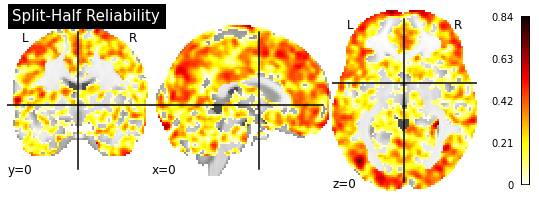

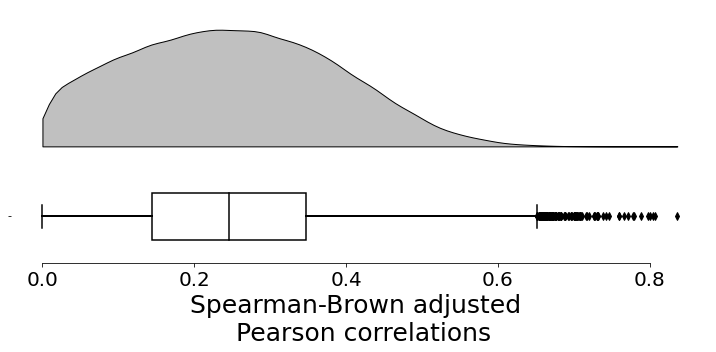

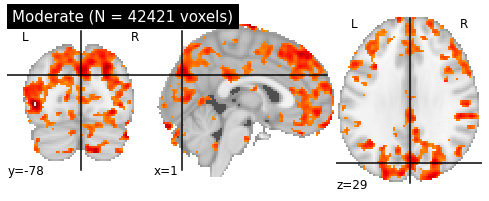

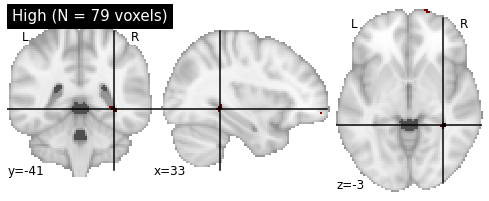

In [15]:
cmap = plotting.cm.cold_white_hot

plotting.plot_stat_map(look_neg_reliability, cut_coords=(0,0,0), title="Split-Half Reliability", 
                      cmap=cmap)
plt.savefig("../plots/split_half_reliabilities/look_neg_look_neut/look_neg_look_neut_reliability.svg", dpi=300)
plt.savefig("../plots/split_half_reliabilities/look_neg_look_neut/look_neg_look_neut_reliability.png", dpi=300)
plt.savefig("../plots/split_half_reliabilities/look_neg_look_neut/look_neg_look_neut_reliability.pdf", dpi=300)

fig, ax = plt.subplots(figsize=(10, 5))
violin = pt.half_violinplot(look_neg_reliability.get_fdata()[look_neg_reliability.get_fdata()>0],  
                   bw = .1, cut = 0,
                   color="silver", linewidth=1, alpha=1,
                   scale = "area", width = .5, inner = None, orient = "h", ax=ax)
violin.collections[0].set_edgecolors('black')

sns.boxplot(look_neg_reliability.get_fdata()[look_neg_reliability.get_fdata()>0], 
               color = "black", width = .10, zorder = 10,
               showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
               showfliers=True, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = "h", ax=ax)
plt.xlabel("Spearman-Brown adjusted \n Pearson correlations", size=25)
plt.tick_params(labelsize=20)
plt.ylim([0.1, -0.45])
sns.despine(offset=0, trim=True, ax=ax)
plt.tight_layout()
plt.savefig("../plots/split_half_reliabilities/look_neg_look_neut/look_neg_look_neut_reliability_histo.svg", dpi=300)
plt.savefig("../plots/split_half_reliabilities/look_neg_look_neut/look_neg_look_neut_reliability_histo.png", dpi=300)
plt.savefig("../plots/split_half_reliabilities/look_neg_look_neut/look_neg_look_neut_reliability_histo.pdf", dpi=300)

vmax = look_neg_reliability.get_fdata().max()
print("vmax = %f" % vmax)

moderate_rel = image.math_img("img*((img > %f) & (img <= %f))" % (0.35, 0.67), img=look_neg_reliability)

n_voxels = np.sum(moderate_rel.get_fdata()>0)
plotting.plot_stat_map(moderate_rel, 
                       cmap=cmap, #colors.ListedColormap([cmap(0.75)], N=1),#plt.cm.Wistia,
                       vmax=vmax,
                       title="Moderate (N = %d voxels)" % n_voxels,
                       colorbar=False)

plt.savefig("../plots/split_half_reliabilities/look_neg_look_neut/look_neg_look_neut_reliability_moderate.svg", dpi=300)
plt.savefig("../plots/split_half_reliabilities/look_neg_look_neut/look_neg_look_neut_reliability_moderate.png", dpi=300)
plt.savefig("../plots/split_half_reliabilities/look_neg_look_neut/look_neg_look_neut_reliability_moderate.pdf", dpi=300)

high_rel = image.math_img("img*(img > %f)" % (0.67), img=look_neg_reliability)
n_voxels = np.sum(high_rel.get_fdata()>0)

plotting.plot_stat_map(high_rel, 
                       vmax=vmax,
                       cmap=cmap,#colors.ListedColormap([cmap(0.9)], N=1),
                       title="High (N = %d voxels)" % n_voxels,
                       colorbar=False)


plt.savefig("../plots/split_half_reliabilities/look_neg_look_neut/look_neg_look_neut_reliability_high.svg", dpi=300)
plt.savefig("../plots/split_half_reliabilities/look_neg_look_neut/look_neg_look_neut_reliability_high.png", dpi=300)
plt.savefig("../plots/split_half_reliabilities/look_neg_look_neut/look_neg_look_neut_reliability_high.pdf", dpi=300)